In [1]:
# 1. Import thư viện cần thiết
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM


import plotly.graph_objects as go
import plotly.express as px

In [2]:
# 2. Đọc file csv
df = pd.read_csv('HSG Historical Data.csv')
df

,Date,Price,Open,High,Low,Vol.,Change %
0,06/02/2023,"15,500.0","15,250.0","15,700.0","15,250.0",15.49M,1.97%
1,06/01/2023,"15,200.0","15,300.0","15,350.0","14,950.0",15.03M,-1.30%
2,05/31/2023,"15,400.0","15,800.0","15,850.0","15,200.0",36.23M,-2.84%
3,05/30/2023,"15,850.0","15,800.0","16,000.0","15,600.0",13.35M,0.96%
4,05/29/2023,"15,700.0","15,500.0","15,700.0","15,350.0",9.60M,2.28%
...,...,...,...,...,...,...,...
1366,12/07/2017,"14,666.1","15,098.3","15,184.8","14,550.9",5.52M,-1.55%
1367,12/06/2017,"14,896.6","14,464.4","15,069.5","14,320.4",9.47M,2.58%
1368,12/05/2017,"14,522.1","15,040.7","15,242.4","14,522.1",12.28M,-1.75%
1369,12/04/2017,"14,781.4","14,061.0","14,781.4","13,830.5",13.71M,6.88%


In [3]:
# convert date field from string to Date format and make it index
def tranformData(df: pd.DataFrame):
  df['Date'] = pd.to_datetime(df.Date, format='%m/%d/%Y')
  df['Price'] = df['Price'].astype(str).apply(lambda x: float(x.replace(',', '')))
  df['Open'] = df['Open'].astype(str).apply(lambda x: float(x.replace(',', '')))
  df['High'] = df['High'].astype(str).apply(lambda x: float(x.replace(',', '')))
  df['Low'] = df['Low'].astype(str).apply(lambda x: float(x.replace(',', '')))
  def convert_to_number(x):
      if 'M' in x:
          return float(x.replace('M', '')) * 1000000
      elif 'K' in x:
          return float(x.replace('K', '')) * 1000
      else:
          return float(x)
  df['Vol.'] = df['Vol.'].apply(convert_to_number)
  df['Change %'] = df['Change %'].apply(lambda x: float(x.strip('%'))/100)

In [4]:
tranformData(df)
df

,Date,Price,Open,High,Low,Vol.,Change %
0,2023-06-02,15500.0,15250.0,15700.0,15250.0,15490000.0,0.0197
1,2023-06-01,15200.0,15300.0,15350.0,14950.0,15030000.0,-0.0130
2,2023-05-31,15400.0,15800.0,15850.0,15200.0,36230000.0,-0.0284
3,2023-05-30,15850.0,15800.0,16000.0,15600.0,13350000.0,0.0096
4,2023-05-29,15700.0,15500.0,15700.0,15350.0,9600000.0,0.0228
...,...,...,...,...,...,...,...
1366,2017-12-07,14666.1,15098.3,15184.8,14550.9,5520000.0,-0.0155
1367,2017-12-06,14896.6,14464.4,15069.5,14320.4,9470000.0,0.0258
1368,2017-12-05,14522.1,15040.7,15242.4,14522.1,12280000.0,-0.0175
1369,2017-12-04,14781.4,14061.0,14781.4,13830.5,13710000.0,0.0688


In [5]:
df=df.sort_values(['Date'])
df1=df.reset_index()['Price']
df

,Date,Price,Open,High,Low,Vol.,Change %
1370,2017-12-01,13830.5,13772.9,13917.0,13657.6,4410000.0,0.0084
1369,2017-12-04,14781.4,14061.0,14781.4,13830.5,13710000.0,0.0688
1368,2017-12-05,14522.1,15040.7,15242.4,14522.1,12280000.0,-0.0175
1367,2017-12-06,14896.6,14464.4,15069.5,14320.4,9470000.0,0.0258
1366,2017-12-07,14666.1,15098.3,15184.8,14550.9,5520000.0,-0.0155
...,...,...,...,...,...,...,...
4,2023-05-29,15700.0,15500.0,15700.0,15350.0,9600000.0,0.0228
3,2023-05-30,15850.0,15800.0,16000.0,15600.0,13350000.0,0.0096
2,2023-05-31,15400.0,15800.0,15850.0,15200.0,36230000.0,-0.0284
1,2023-06-01,15200.0,15300.0,15350.0,14950.0,15030000.0,-0.0130


In [6]:
df.describe()

,Price,Open,High,Low,Vol.,Change %
count,1371.000000,1371.000000,1371.000000,1371.000000,1.371000e+03,1371.000000
mean,14427.441284,14450.158133,14748.419037,14167.371335,9.892545e+06,0.000599
std,9763.865767,9787.401082,9961.580302,9603.698810,6.292617e+06,0.031914
min,3282.800000,3246.800000,3463.200000,3145.700000,8.300100e+05,-0.070000
25%,6031.700000,6033.050000,6132.800000,5955.700000,4.775000e+06,-0.016900
50%,12450.000000,12450.000000,12700.000000,12159.100000,8.760000e+06,0.000000
75%,17994.300000,18094.700000,18492.400000,17750.000000,1.371500e+07,0.017850
max,41541.700000,41750.000000,42750.000000,41333.300000,3.671000e+07,0.070000


In [7]:
fig = px.line(df, x=df.Date, y=df.Price,labels={'Date':'Date','Price':'Close Stock'})
fig.update_traces(marker_line_width=2, opacity=0.6)
fig.update_layout(title_text='Stock close price for chart of HSG', plot_bgcolor='white', font_size=15, font_color='black')
fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()

In [8]:
# 3. Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [9]:
# 4. Chia train test
train_size = int(0.6 * len(df1))
test_size = int(0.2 * len(df1))
val_size = len(df1) - train_size - test_size

train_data = df1[:train_size]
test_data = df1[train_size:train_size+test_size]
val_data = df1[train_size+test_size:]

In [10]:
# 5. Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [11]:
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100

time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_val, yval = create_dataset(val_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [12]:
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)
X_val = X_val.reshape(X_val.shape[0],X_val.shape[1] , 1)

In [13]:
# 8. Define LSTM Model

model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(100,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [14]:
# 9. Fit mô hình với dữ liệu train
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
12/12 [==============================] - 10s 347ms/step - loss: 0.0071 - val_loss: 0.0138
Epoch 2/100
12/12 [==============================] - 3s 272ms/step - loss: 0.0012 - val_loss: 0.0163
Epoch 3/100
12/12 [==============================] - 2s 198ms/step - loss: 5.8754e-04 - val_loss: 0.0073
Epoch 4/100
12/12 [==============================] - 2s 198ms/step - loss: 5.0731e-04 - val_loss: 0.0139
Epoch 5/100
12/12 [==============================] - 2s 200ms/step - loss: 4.6143e-04 - val_loss: 0.0096
Epoch 6/100
12/12 [==============================] - 3s 242ms/step - loss: 4.2464e-04 - val_loss: 0.0130
Epoch 7/100
12/12 [==============================] - 5s 406ms/step - loss: 3.9032e-04 - val_loss: 0.0221
Epoch 8/100
12/12 [==============================] - 3s 273ms/step - loss: 3.9002e-04 - val_loss: 0.0165
Epoch 9/100
12/12 [==============================] - 2s 198ms/step - loss: 3.7722e-04 - val_loss: 0.0099
Epoch 10/100
12/12 [==============================] - 3s 270ms

In [15]:
# 10. Dự báo dữ liệu test, val
train_predict=model.predict(X_train)
y_pred=model.predict(X_test)
y_pred_val=model.predict(X_val)

6/6 [==============================] - 0s 43ms/step


In [16]:
# 11. Chuẩn hóa dữ liệu y_pred, y_pred_val
train_predict=scaler.inverse_transform(train_predict)
y_pred=scaler.inverse_transform(y_pred)
y_pred_val=scaler.inverse_transform(y_pred_val)

In [18]:
# 13. Dự báo 30 ngày tiếp theo
x_input=val_data[-100:].reshape(1,-1)
x_input.shape

temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output=[]
n_steps=100
i=0
while(i<30):

    if(len(temp_input)>100):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1


[0.31963265]
101
1 day input [0.25921289 0.24483715 0.24091649 0.25006469 0.25659912 0.25921289
 0.25659912 0.27228174 0.29711257 0.2944988  0.2944988  0.30495388
 0.30495388 0.31932962 0.29711257 0.29319191 0.29841945 0.2944988
 0.26836109 0.29188503 0.28665748 0.29057814 0.29057814 0.30234011
 0.30887454 0.32847782 0.31932962 0.33762602 0.32717093 0.30626077
 0.32717093 0.31148831 0.29057814 0.2944988  0.32063651 0.31932962
 0.31410208 0.31540896 0.33501225 0.3389329  0.3389329  0.34285356
 0.33762602 0.32063651 0.34677421 0.33501225 0.33762602 0.32455716
 0.33501225 0.32847782 0.33239847 0.3297847  0.34154667 0.3389329
 0.34677421 0.3389329  0.33501225 0.33762602 0.34416044 0.35069487
 0.34285356 0.33762602 0.32194339 0.32717093 0.32063651 0.30887454
 0.31540896 0.32194339 0.32455716 0.31410208 0.31410208 0.30495388
 0.29580568 0.30495388 0.32455716 0.31410208 0.31932962 0.31932962
 0.32063651 0.32194339 0.33109159 0.33109159 0.33501225 0.34023979
 0.3297847  0.32717093 0.31932962 0

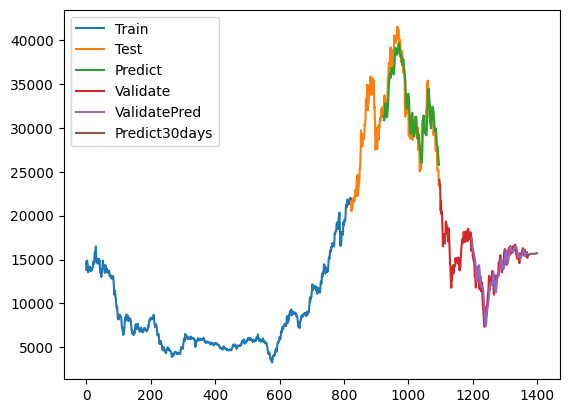

In [19]:
# 14.Vẽ hình

train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))
test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))
test_data_index = pd.RangeIndex(start=train_size+101, stop=train_size+test_size, step=1)
plt.plot(test_data_index,(y_pred))
val_data_index = pd.RangeIndex(start=train_size+test_size, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,scaler.inverse_transform(val_data))
val_data_index = pd.RangeIndex(start=train_size+test_size+101, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,y_pred_val)
prediect_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+29, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(lst_output))
plt.legend(['Train','Test','Predict','Validate','ValidatePred','Predict30days'])
plt.show()

In [20]:
yval=scaler.inverse_transform(yval.reshape(-1, 1))
ytest=scaler.inverse_transform(ytest.reshape(-1, 1))

In [21]:
# 12. Đánh giá độ chính xác thuật toán bằng RMSE
valid_rmse = np.sqrt(np.mean((y_pred_val - yval)**2))
test_rmse = np.sqrt(np.mean((y_pred - ytest)**2))
print('Validation RMSE:', valid_rmse)
print('Testing RMSE:', test_rmse)
from sklearn.metrics import mean_absolute_percentage_error


vail_mape = mean_absolute_percentage_error(yval, y_pred_val)
test_mape = mean_absolute_percentage_error(ytest, y_pred)
print('Validation MAPE:', vail_mape)
print('Testing MAPE:', test_mape)

Validation RMSE: 796.0629351639807
Testing RMSE: 1523.905020907153
Validation MAPE: 0.04899040239038441
Testing MAPE: 0.03855022281245802
